# SARIMAX

In [16]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')

In [17]:
# Sample data with two exogenous variables
data = {
    'Date': pd.to_datetime(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', 
                           '2023-01-06', '2023-01-07', '2023-01-08', '2023-01-09', '2023-01-10']),
    'Value': [10, 12, 15, 18, 20, 17, 19, 22, 25, 28],
    'Exog1': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    'Exog2': [100, 105, 110, 115, 120, 125, 130, 135, 140, 145]
}
df = pd.DataFrame(data)
df = df.set_index('Date')
df.head()

,Value,Exog1,Exog2
Date,,,
2023-01-01,10,5,100
2023-01-02,12,6,105
2023-01-03,15,7,110
2023-01-04,18,8,115
2023-01-05,20,9,120


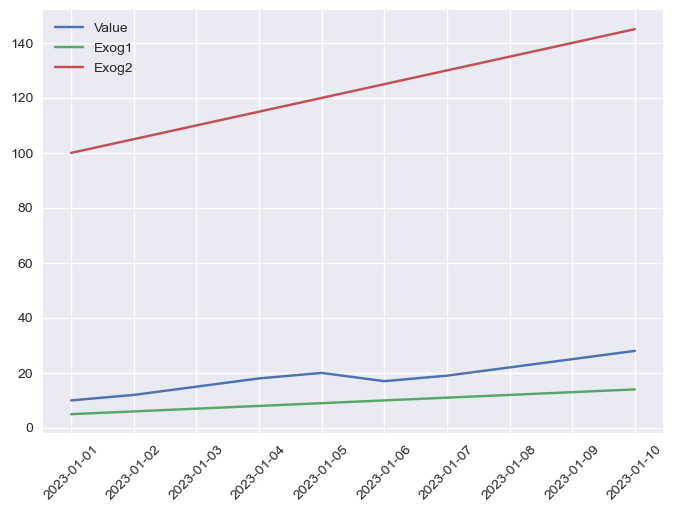

In [19]:
plt.plot(df['Value'], label='Value')
plt.plot(df['Exog1'], label='Exog1')
plt.plot(df['Exog2'], label='Exog2')
plt.xticks(rotation=45)
plt.legend()
plt.show()

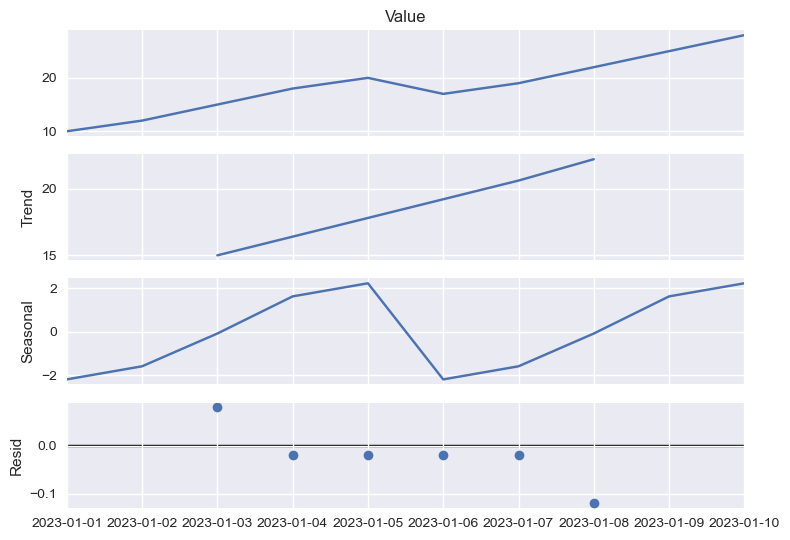

ADF Statistic: -0.254451
p-value: 0.931712
Best SARIMA order: (2, 0, 1)
Best seasonal order: (1, 0, 1, 5)
RMSE on validation set: 0.6690579906666584


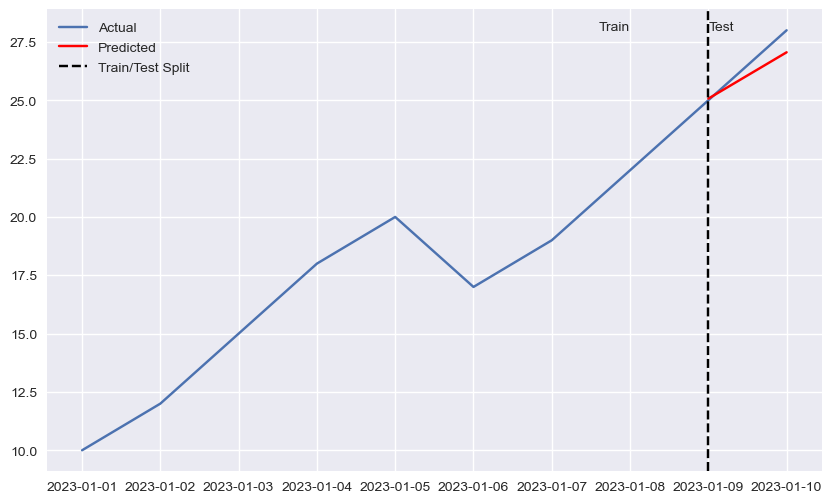

In [14]:
# 1. Check for seasonality with a reduced period
if len(df) >= 5:  # Ensure there are enough observations
    result = seasonal_decompose(df['Value'], model='additive', period=5)
    result.plot()
    plt.show()
else:
    print("Not enough data for seasonal decomposition")

# 2. Check for stationarity
result = adfuller(df['Value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# 3. Split data into train and validation sets
train_data, val_data = train_test_split(df, test_size=0.2, shuffle=False)

# Ensure train and validation sets are not empty
if len(train_data) == 0 or len(val_data) == 0:
    raise ValueError("Train or validation data is empty")

# 4. Determine best p, d, q, P, D, Q fit
def evaluate_sarima_model(train, val, order, seasonal_order):
    try:
        # Fit the model
        model = SARIMAX(train['Value'], order=order, seasonal_order=seasonal_order, exog=train[['Exog1', 'Exog2']])
        model_fit = model.fit(disp=False)
        # Make predictions
        if len(val) == 0:
            raise ValueError("Validation data is empty for predictions")
        predictions = model_fit.predict(start=len(train), end=len(train) + len(val) - 1, exog=val[['Exog1', 'Exog2']])
        # Evaluate model
        rmse = mean_squared_error(val['Value'], predictions, squared=False)
        return rmse
    except Exception as e:
        print(f'Error evaluating SARIMA model with order {order} and seasonal order {seasonal_order}: {e}')
        return None

# Define ranges for p, d, q, P, D, Q
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)
m = 5  # Seasonal period

# Loop through possible values
best_rmse = float('inf')
best_order = None
best_seasonal_order = None
for p_val in p:
    for d_val in d:
        for q_val in q:
            for P_val in P:
                for D_val in D:
                    for Q_val in Q:
                        order = (p_val, d_val, q_val)
                        seasonal_order = (P_val, D_val, Q_val, m)
                        rmse = evaluate_sarima_model(train_data, val_data, order, seasonal_order)
                        if rmse is not None and rmse < best_rmse:
                            best_rmse = rmse
                            best_order = order
                            best_seasonal_order = seasonal_order

print(f'Best SARIMA order: {best_order}')
print(f'Best seasonal order: {best_seasonal_order}')

# 5. Fit the final model using the best p, d, q, P, D, Q values
model = SARIMAX(train_data['Value'], order=best_order, seasonal_order=best_seasonal_order, exog=train_data[['Exog1', 'Exog2']])
model_fit = model.fit(disp=False)

# 6. Make predictions on validation set
if len(val_data) == 0:
    raise ValueError("Validation data is empty for final predictions")
predictions = model_fit.predict(start=len(train_data), end=len(df)-1, exog=val_data[['Exog1', 'Exog2']])

# 7. Evaluate the model
rmse = mean_squared_error(val_data['Value'], predictions, squared=False)
print(f'RMSE on validation set: {rmse}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Value'], label='Actual')
plt.plot(val_data.index, predictions, label='Predicted', color='red')
plt.axvline(x=val_data.index[0], color='k', linestyle='--', label='Train/Test Split')
plt.text(train_data.index[-1], max(df['Value']), 'Train', horizontalalignment='right')
plt.text(val_data.index[0], max(df['Value']), 'Test', horizontalalignment='left')
plt.legend()
plt.show()

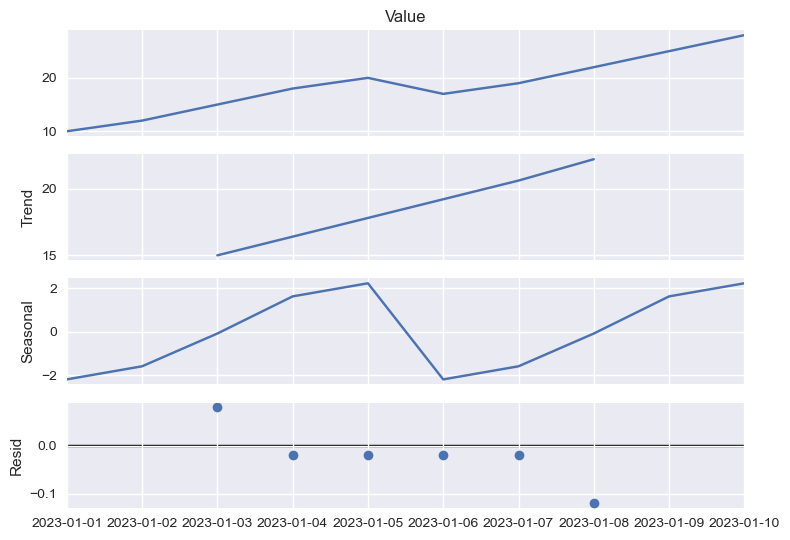

Best SARIMA order: (2, 1, 1)
Best seasonal order: (1, 0, 1, 5)
RMSE on validation set: 0.704651707907607


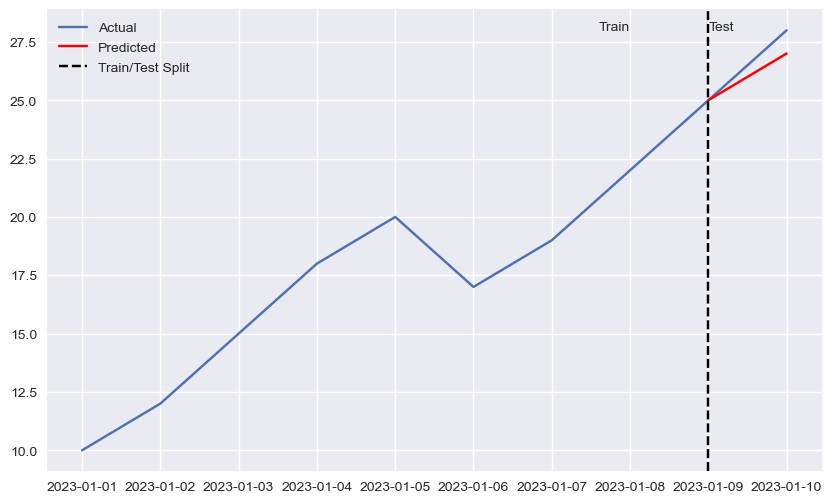

In [20]:
# 1. Check for seasonality with a reduced period
if len(df) >= 5:  # Ensure there are enough observations
    result = seasonal_decompose(df['Value'], model='additive', period=5)
    result.plot()
    plt.show()
else:
    print("Not enough data for seasonal decomposition")

# 3. Split data into train and validation sets
train_data, val_data = train_test_split(df, test_size=0.2, shuffle=False)

# Ensure train and validation sets are not empty
if len(train_data) == 0 or len(val_data) == 0:
    raise ValueError("Train or validation data is empty")

# 4. Determine best p, d, q, P, D, Q fit
def evaluate_sarima_model(train, val, order, seasonal_order):
    try:
        # Fit the model
        model = SARIMAX(train['Value'], order=order, seasonal_order=seasonal_order, exog=train[['Exog1', 'Exog2']])
        model_fit = model.fit(disp=False)
        # Make predictions
        if len(val) == 0:
            raise ValueError("Validation data is empty for predictions")
        predictions = model_fit.predict(start=len(train), end=len(train) + len(val) - 1, exog=val[['Exog1', 'Exog2']])
        # Evaluate model
        rmse = mean_squared_error(val['Value'], predictions, squared=False)
        return rmse
    except Exception as e:
        print(f'Error evaluating SARIMA model with order {order} and seasonal order {seasonal_order}: {e}')
        return None

# Define ranges for p, d, q, P, D, Q
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)
m = 5  # Seasonal period

# Loop through possible values
best_rmse = float('inf')
best_order = None
best_seasonal_order = None
for p_val in p:
    for d_val in d:
        for q_val in q:
            for P_val in P:
                for D_val in D:
                    for Q_val in Q:
                        order = (p_val, 1, q_val)  # Set d=1 for differencing
                        seasonal_order = (P_val, D_val, Q_val, m)
                        rmse = evaluate_sarima_model(train_data, val_data, order, seasonal_order)
                        if rmse is not None and rmse < best_rmse:
                            best_rmse = rmse
                            best_order = order
                            best_seasonal_order = seasonal_order

print(f'Best SARIMA order: {best_order}')
print(f'Best seasonal order: {best_seasonal_order}')

# 5. Fit the final model using the best p, d, q, P, D, Q values
model = SARIMAX(train_data['Value'], order=best_order, seasonal_order=best_seasonal_order, exog=train_data[['Exog1', 'Exog2']])
model_fit = model.fit(disp=False)

# 6. Make predictions on validation set
if len(val_data) == 0:
    raise ValueError("Validation data is empty for final predictions")
predictions = model_fit.predict(start=len(train_data), end=len(df)-1, exog=val_data[['Exog1', 'Exog2']])

# 7. Evaluate the model
rmse = mean_squared_error(val_data['Value'], predictions, squared=False)
print(f'RMSE on validation set: {rmse}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Value'], label='Actual')
plt.plot(val_data.index, predictions, label='Predicted', color='red')
plt.axvline(x=val_data.index[0], color='k', linestyle='--', label='Train/Test Split')
plt.text(train_data.index[-1], max(df['Value']), 'Train', horizontalalignment='right')
plt.text(val_data.index[0], max(df['Value']), 'Test', horizontalalignment='left')
plt.legend()
plt.show()

## Explanation:
1. **Check for Seasonality:** Uses seasonal_decompose to check for seasonality in the data.  
2. **Check for Stationarity:** Uses adfuller to perform the Augmented Dickey-Fuller test for stationarity.  
3. **Split Data:** Splits the dataset into training and validation sets.  
4. **Determine Best SARIMA Model:** Loops through possible values of p, d, q, P, D, Q to find the best model based on RMSE.
5. **Fit Final Model:** Fits the final SARIMA model using the best parameters.  
6. **Make Predictions:** Makes predictions on the validation set.  
7. **Evaluate and Plot:** Evaluates the model using RMSE and plots the actual vs. predicted values.  

This example ensures that the data is valid and non-empty at each step to prevent errors.